# Data Analysis
Analysis of line scans taken at the beam. See the `README` in the `Experimental Data` folder.

In [1]:
import utils
from importlib import reload
import itertools

import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import *
from sklearn.metrics.pairwise import cosine_similarity

from scipy.interpolate import interp1d
from scipy.optimize import basinhopping
from scipy.stats import pearsonr

utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Load Reference Data

In [3]:
exp = parse_file('Reference Data/As_exp_standards_normalized.dat')
sim = parse_file('Reference Data/As_edge_sim_standards_phases_normalized.dat')
defect = parse_file('Reference Data/As_defects_normalized.dat')

energy = np.array(sim['X1'], dtype=float)

sim_data_columns = [colm for colm in sim.columns if len(colm.replace('X', '')) > 3]
Sim_Refs = np.array(sim[sim_data_columns], dtype=float).T

exp_data_columns = [colm for colm in exp.columns if len(colm.replace('X', '')) > 3]
Exp_Refs = np.array(exp[exp_data_columns], dtype=float).T

defect_data_columns = [colm for colm in defect.columns if len(colm.replace('X', '')) > 3]
Defect_Refs = np.array(defect[defect_data_columns], dtype=float).T

refs = np.concatenate((Sim_Refs, Exp_Refs, Defect_Refs), axis=0)

Energy = np.linspace(11863, 11915, 5201)
Energy_exp = np.array([11866.5, 11870., 11873.5, 11876.5, 11879., 11885.5, 11900., 11904., 11909.5])

interperlator = interp1d(energy, refs)

Refs = interperlator(Energy)
Refs_exp = interperlator(Energy_exp)

print(f"Resolution: {Energy[1] - Energy[0]}")

data_columns = sim_data_columns + exp_data_columns + defect_data_columns

Resolution: 0.010000000000218279


In [4]:
for i, ele in enumerate(data_columns):
    print(i, ele)

0 As mp 1238842 merged
1 As mp 1182332
2 As mp 1096826
3 As mp 158
4 As mp 10
5 As mp 11
6 CdAs mp 7373
7 Cd3As2 cod4337945 merged
8 CdAs2 mp 471
9 CdAs3 mp 1183659
10 Cd3As mp 1183587
11 TeAs mp 10051
12 Te3As2 mp 484 merged
13 TeAs2 mp 1217320
14 As2Se mp 1228838
15 As2Se3 mp 909 merged
16 As2Se3 mp 1078443 merged
17 As4Se3 mp 1194350 merged
18 AsCl3 cod4317526
19 AsCl3 mp 23280 symmetrized
20 AsCl3O mp 29863 symmetrized
21 exp As 0109 (ASU standard)
22 exp As 0110 (ASU standard)
23 exp As2O3 0111 (ASU standard)
24 exp As2O3 0112 (ASU standard)
25 exp As (FL database)
26 exp As2O3 (XAFS Lib)
27 exp As2O5 (XAFS Lib)
28 CdSe As Cd
29 CdSe As i Cd
30 CdSe As i neut
31 CdSe As i Se
32 CdSe As Se


In [5]:
#choice_indices = np.sort([27, 4, 11, 22, 28, 30, 31, 23, 9, 16, 8, 19])
#for i in range(len(choice_indices)):
#    print(i, data_columns[choice_indices[i]])
#data_columns = [data_columns[i] for i in choice_indices]
#Refs = [Refs[i] for i in choice_indices]

### Visualize References

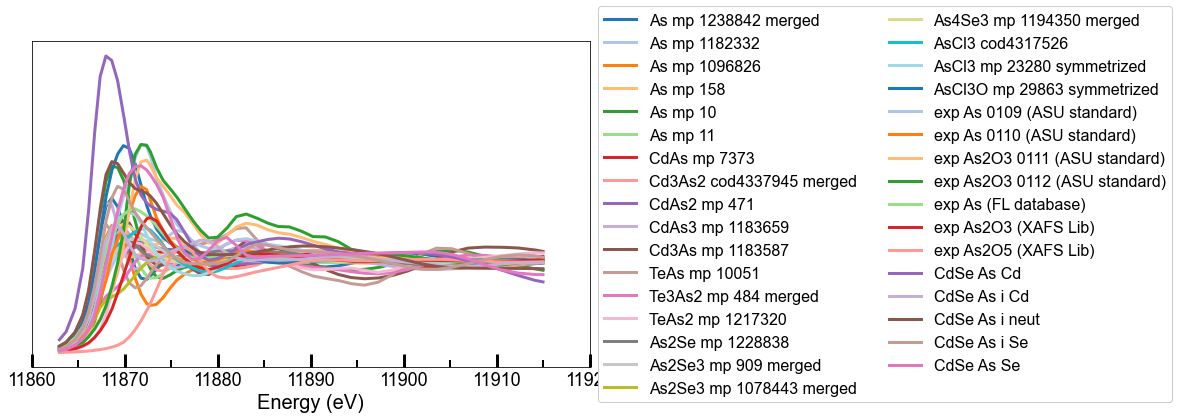

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    label = f'{data_columns[i]}'
    ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20(c/19), label=label, alpha=1.)
ax.legend(fontsize=16, loc='center left', bbox_to_anchor=(1., .5), ncol=2, framealpha=1.)
format_axis(ax, ticks=(5,10))
plt.show()

# Removing similar references

## Enumeration method

In [7]:
def evaluate_similarity(x, y, metric):
    if metric == 'cosine similarity':
        score = cosine_similarity([x], Y=[y])
    elif metric == 'Pearson correlation':
        score, pval = pearsonr(x, y)
    elif metric == '1 - $\delta$':
        score = 1 - np.average(np.abs(x - y))
    return score

In [8]:
def sample_basis(basis, num_iters, subset_size, metric='Pearson correlation'):
    indices = np.arange(basis.shape[0])
    total_score = []
    for i in range(num_iters):
        print(i + 1, end='\r')
        subset_indices = np.random.choice(indices, size=subset_size, replace=False)
        
        subset = np.array([ele for i, ele in enumerate(basis) if i in subset_indices])
        non_subset = np.array([ele for i, ele in enumerate(basis) if i not in subset_indices])
        
        coeffs_hat = get_coeffs_from_spectra(non_subset, subset, scaling=False, tol=None,
                                             metric='mean_squared_error', lambda1=0, lambda2=2.)
        recons = coeffs_hat @ subset
        scores = [evaluate_similarity(x, y, metric) for x, y in zip(non_subset, recons)]
        total_score.append(np.average(scores))
    return np.average(np.array(total_score))

In [9]:
sizes = np.arange(3, 28, 1)
scores = []
for subset_size in sizes:
    print(f'    iteration for subset size {subset_size}', end='\r')
    score = sample_basis(Refs, 50, subset_size)
    scores.append(score)
print(scores)

[0.8668809240077497, 0.8789814023843292, 0.8947549596513563, 0.9071783038097025, 0.9125779412774861, 0.9149059128114964, 0.9236116153409799, 0.9248916042965405, 0.9290858005130217, 0.9343683361308749, 0.9370350341019911, 0.9384147950148721, 0.9386064123649136, 0.939496108146907, 0.9459457971092969, 0.9454940065772642, 0.9447525651660102, 0.9478944369271219, 0.9462859746330161, 0.9482384754409197, 0.9485067080975524, 0.9514789928600388, 0.9545641677235092, 0.9545281417023866, 0.951450863464059]


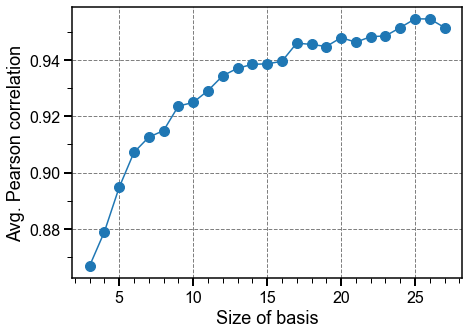

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))

plt.plot(sizes, scores, 'o-', markersize=10, c=plt.cm.tab20(0))

ax.set_ylabel('Avg. Pearson correlation', fontsize=18)
ax.set_xlabel('Size of basis', fontsize=18)

ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.tick_params(direction='out', width=2, length=8, which='major', axis='both')
ax.tick_params(direction='out', width=1, length=5, which='minor', axis='both')

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)

for x in ax.get_xticks()[1:-1]:
    plt.axvline(x, linestyle='--', c='gray', linewidth=1, zorder=0)

for y in ax.get_yticks()[1:-1]:
    plt.axhline(y, linestyle='--', c='gray', linewidth=1, zorder=0)

set_spine_width(ax, width=1.5)
plt.savefig(f'Figures/Pearson_corr_vs_basis_size.png', dpi=800, transparent=True, bbox_inches='tight')

# Correlation matrices

In [241]:
#metric = 'cosine similarity'
metric = 'Pearson correlation'
#metric = '1 - $\delta$'

In [242]:
data_columns

['As mp 10',
 'CdAs2 mp 471',
 'CdAs3 mp 1183659',
 'TeAs mp 10051',
 'As2Se3 mp 1078443 merged',
 'AsCl3 mp 23280 symmetrized',
 'exp As 0110 (ASU standard)',
 'exp As2O3 0111 (ASU standard)',
 'exp As2O5 (XAFS Lib)',
 'CdSe As Cd',
 'CdSe As i neut',
 'CdSe As i Se']

In [249]:
N = len(data_columns)
Similarity_matrix = np.zeros((N, N))
for i, j in itertools.product(range(N), range(N)):
    if i <= j:
        score = evaluate_similarity(Refs[i], Refs[j], metric)
        Similarity_matrix[i, j] = score
        Similarity_matrix[j, i] = score

threshold = 0.9
for i, j in itertools.product(range(N), range(N)):
    if threshold is not None:
        if Similarity_matrix[i, j] < threshold:
            Similarity_matrix[i, j] = 0

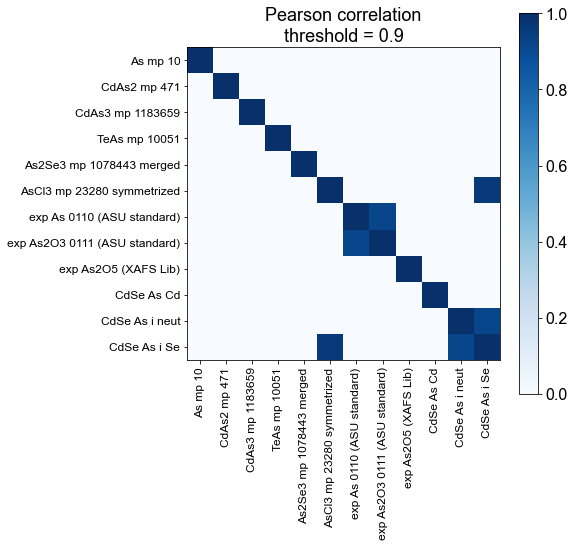

In [250]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(Similarity_matrix, cmap='Blues', interpolation='nearest')
if threshold is None:
    plt.title(f'{metric}', fontsize=18)
else:
    plt.title(f'{metric}\nthreshold = {threshold}', fontsize=18)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)

ax.set_yticks(np.arange(N))
ax.set_yticklabels(data_columns, fontsize=12)

ax.set_xticks(np.arange(N))
ax.set_xticklabels(data_columns, fontsize=12, rotation=90)

metric = metric.replace('$', '').replace('\\', '')
plt.savefig(f'Figures/{metric} matrix thresh {threshold} filtered.png', dpi=800, transparent=True, bbox_inches='tight')

In [251]:
n = np.sum([1 for i, j in itertools.product(range(N), range(N)) if i < j and Similarity_matrix[i, j] != 0])
print(n)

3


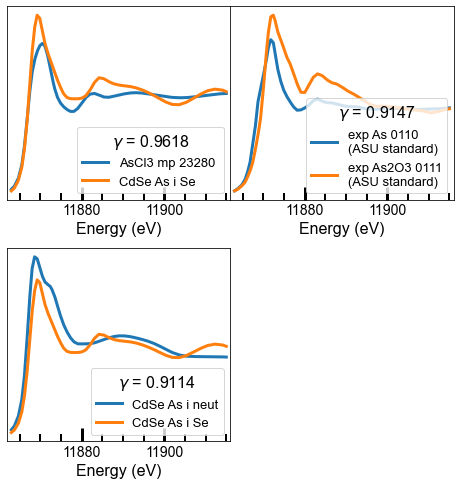

In [255]:
ncols = 2
nrows = n//ncols
if nrows * ncols < n:
    nrows += 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(ncols * 4, nrows * 4))
plt.subplots_adjust(wspace=0., hspace=0.25)

k = 0
for i, j in itertools.product(range(N), range(N)):
    if i < j:
        if Similarity_matrix[i, j] != 0:
            row, colm = np.unravel_index(k, (nrows, ncols))
            ax = axes[row, colm]
            ax.plot(Energy, Refs[i], '-', linewidth=3, c=plt.cm.tab20(0),
                    label=data_columns[i].replace('merged', '').replace('symmetrized', '').replace(' (', '\n('))
            ax.plot(Energy, Refs[j], '-', linewidth=3, c=plt.cm.tab20(2),
                    label=data_columns[j].replace('merged', '').replace('symmetrized', '').replace(' (', '\n('))
            ax.legend(fontsize=13, loc=4, title=f'$\\gamma$ = {Similarity_matrix[i, j]:.4f}',
                      title_fontsize=16)
            format_axis(ax, ticks=(5, 20), fontsize=16)
            ax.set_xlim(11862, 11916)
            k += 1

for i, j in itertools.product(range(nrows), range(ncols)):
    idx = (i * ncols) + j + 1
    if idx > n:
        axes[i, j].axis('off')

plt.savefig(f'Figures/{metric} pairing of spectra filtered.png', dpi=800, transparent=True, bbox_inches='tight')

In [256]:
hist = []
for i in range(N):
    num_nonzero = 0
    for j in range(N):
        if i < j and Similarity_matrix[i, j] != 0:
            num_nonzero += 1
    hist.append(num_nonzero)
hist = np.array(hist)

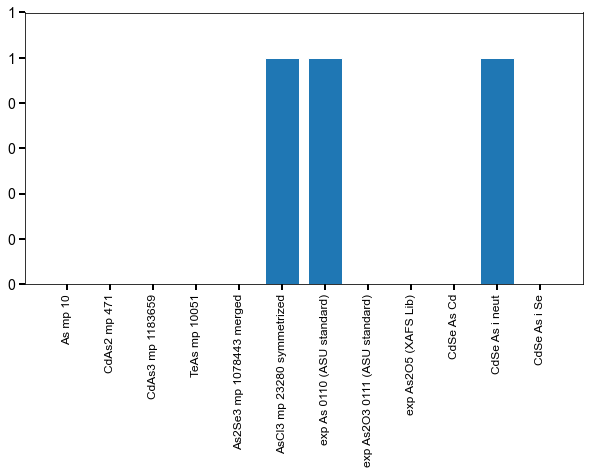

In [258]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.arange(N), hist, color=plt.cm.tab20(0), edgecolor='w')

ax.tick_params(direction='out', width=2, length=6, axis='both')

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(np.array(ax.get_yticks(), dtype=int), fontsize=14)
ax.set_xticks(np.arange(N))
ax.set_xticklabels(data_columns, fontsize=12, rotation=90)

plt.savefig(f'Figures/histogram of matches filtered.png', dpi=800, transparent=True, bbox_inches='tight')

# Dendrogram

In [259]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

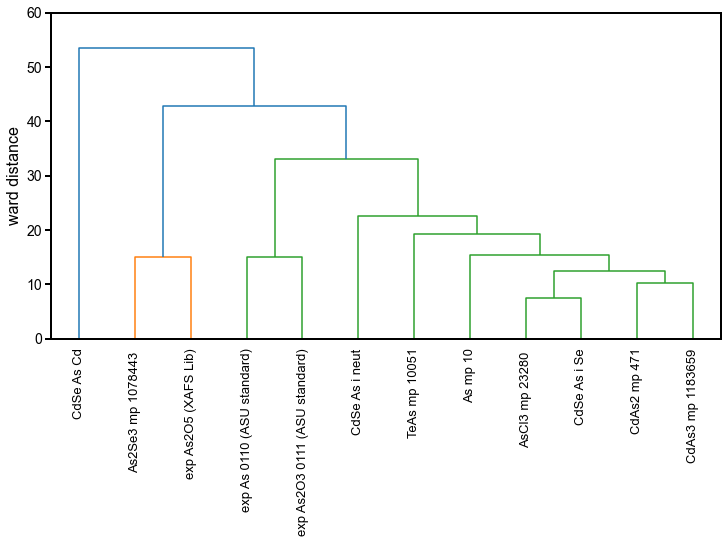

In [261]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(Refs)

fig, ax = plt.subplots(figsize=(12, 6))

def labeller(i):
    if i < len(data_columns):
        return data_columns[i].replace('merged', '').replace('symmetrized', '')
    else:
        return i

kwargs = {'leaf_font_size': 13, 'leaf_rotation': 90, 'leaf_label_func': labeller}
plot_dendrogram(model, truncate_mode="level", p=9, **kwargs)

ax.tick_params(direction='out', width=2, length=6, axis='both')
ax.set_yticks(ax.get_yticks())
ax.set_ylabel('ward distance', fontsize=16)
ax.set_yticklabels(np.array(ax.get_yticks(), dtype=int), fontsize=14)

#plt.axhline(y=12, c='k', linestyle='--', linewidth=2)
set_spine_width(ax, 2)

plt.savefig(f'Figures/dendrogram_of_refs_filtered.png', dpi=800, transparent=True, bbox_inches='tight')

## Analyze references taken at beam

In [262]:
standard_fnames = ['lineAs_metal_scan006.mda.csv', 'lineCd3As2_scan008.mda.csv',
                   'lineAs2O3_scan009.mda.csv', 'lineAs3Te2_scan011.mda.csv']
standards = ['As metal', '$Cd_3As_2$', '$As_2O_3$', '$As_3Te_2$']
dfs = [pd.read_csv(f'Experimental data/Arsenic standards/{filename}') for filename in standard_fnames]
dfs = [preprocess_df(df) for df in dfs]

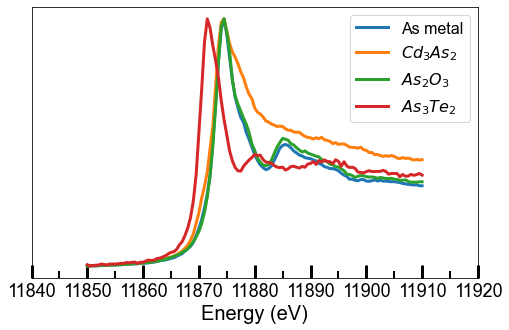

In [83]:
fig, ax = plt.subplots(figsize=(8, 5))

for i, label in enumerate(standards):
    x, y = get_xy_from_colms(dfs[i], 'Energy (keV)', 'I_0 (a.u.)')
    ax.plot(x, y, '-', linewidth=3, c=plt.cm.tab20(i*2), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

2.7399999999997817


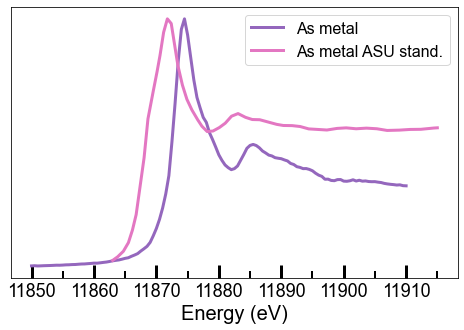

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[0], 'Energy (keV)', 'I_0 (a.u.)')
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(8), label=standards[0])

x2 = Energy
y2 = Refs[22]
y2 = y2 / np.max(y2)
label = 'As metal ASU stand.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(12), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

5.25


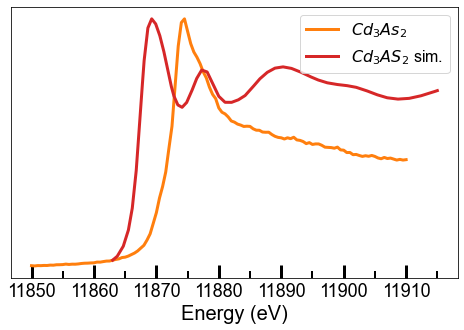

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[1], 'Energy (keV)', 'I_0 (a.u.)')
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(2), label=standards[1])

x2 = Energy
y2 = Refs[7]
y2 = y2 / np.max(y2)
label = '$Cd_3AS_2$ sim.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(6), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

2.7399999999997817


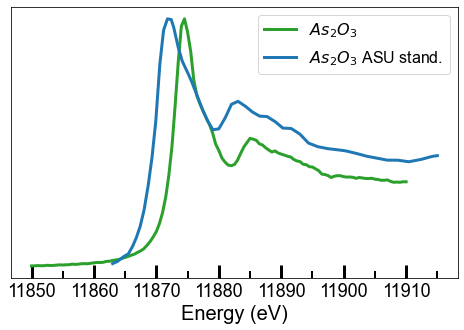

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[2], 'Energy (keV)', 'I_0 (a.u.)')
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(4), label=standards[2])

x2 = Energy
y2 = Refs[24]
y2 = y2 / np.max(y2)
label = '$As_2O_3$ ASU stand.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(0), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

## Energy shift
A 2.73 eV energy shift will be applied to all simulated references so that is is aligned with the new experimental data.

In [263]:
def spectral_loss(x, spectrum, target, metric):
    return eval(metric)(x*spectrum, target)

def get_scale(spectrum, target, metric='mean_absolute_error'):
    alpha0 = 0.1
    alpha = minimize(spectral_loss, alpha0, args=(spectrum, target, metric))['x']
    return alpha

In [264]:
exp_energy = np.array(dfs[0]['Energy (keV)'], dtype=float)
print(min(exp_energy)*1000, max(exp_energy)*1000)
print(min(energy) + 2.74, max(energy) + 2.74)

11850.0 11910.0
11859.356 11930.764


In [265]:
energy = energy + 2.74

bool_arr = exp_energy*1000 > 11865
Exp_Energy = exp_energy[bool_arr]*1000
Energy = Exp_Energy.copy()

interperlator = interp1d(energy, refs)

Refs = interperlator(Energy)

0.0
[0.32409579]


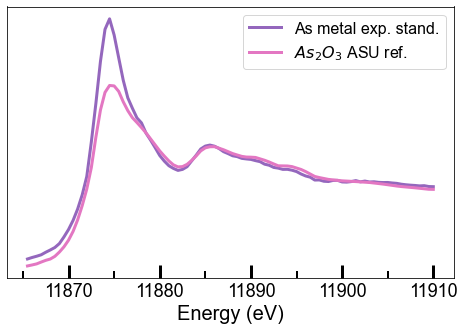

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[0], 'Energy (keV)', 'I_0 (a.u.)')
x1 = x1[bool_arr]
y1 = y1[bool_arr]
label = standards[0] + ' exp. stand.'

ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(8), label=label)

#x2 = Energy
#y2 = Refs[22]
#label = 'As metal ASU ref.'

x2 = Energy
y2 = Refs[24]
label = '$As_2O_3$ ASU ref.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

alpha = get_scale(y2, y1)
print(alpha)
y2 = alpha*y2

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(12), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.savefig('Figures/As_metal_exp_comparison.png', dpi=800, transparent=True)

0.0
[0.33828219]


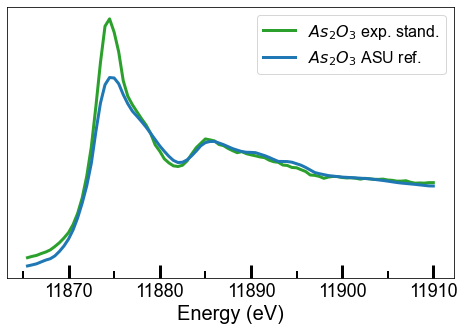

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[2], 'Energy (keV)', 'I_0 (a.u.)')
x1 = x1[bool_arr]
y1 = y1[bool_arr]
label = standards[2] + ' exp. stand.'
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(4), label=label)

x2 = Energy
y2 = Refs[24]
#y2 = y2 / np.max(y2)
label = '$As_2O_3$ ASU ref.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

alpha = get_scale(y2, y1)
print(alpha)
y2 = alpha*y2

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(0), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.savefig('Figures/As2O3_exp_comparison.png', dpi=800, transparent=True)

References after energy shift and scaling

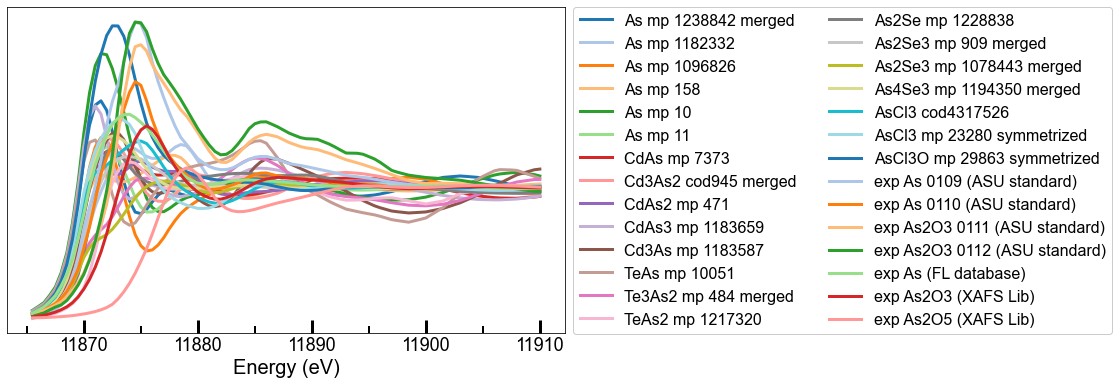

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    label = f'{data_columns[i]}'
    ax.plot(Energy, ref * alpha, '-', linewidth=3, c=plt.cm.tab20(c/19), label=label, alpha=1.)
ax.legend(fontsize=16, loc='center left', bbox_to_anchor=(1., .5), ncol=2, framealpha=1.)
format_axis(ax, ticks=(5,10))
plt.show()

# Visualize the Experimental Data

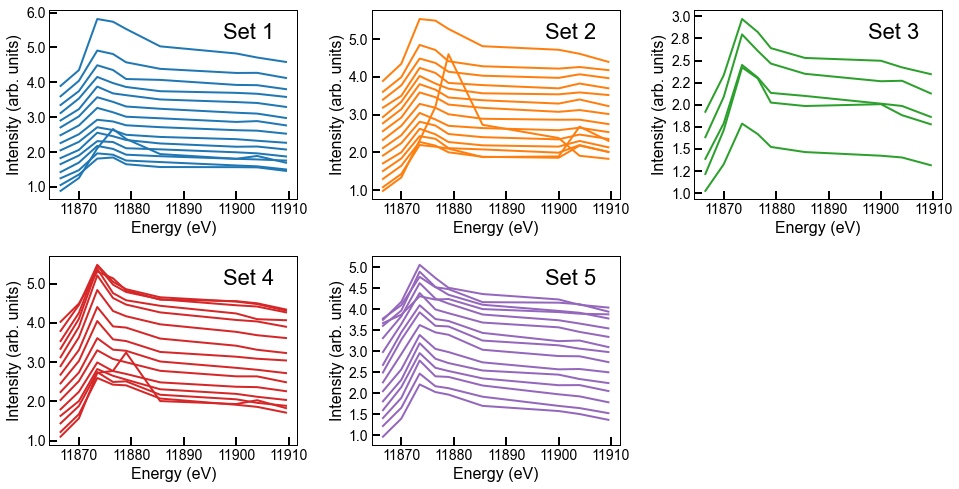

In [266]:
Energies = np.array([11.8665, 11.87, 11.8735, 11.8765, 11.879,
                     11.8855, 11.9, 11.904, 11.9095])
DATA = get_all_data(Energies)
# data is a list (by set) of a list (by pixel number) of dictaries (by xy pos)

nrows = 2
ncols = 3
fig, axes = plt.subplots(figsize=(16, 8), nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for Set in range(1, 7):
    row = (Set - 1) // ncols
    colm = (Set - 1) % ncols
    ax = axes[row, colm]
    if Set <= 5:
        setdata = DATA[Set] 
        for i, pt in enumerate(setdata):
            intensity = np.array(pt['I'], dtype=float)
            ax.plot(pt['E'], intensity / 1000 + i*0.2, '-', linewidth=2, c=plt.cm.tab10(Set - 1))
    
        ax.annotate(f'Set {Set}', (0.7, 0.85), xycoords='axes fraction', fontsize=22)
        ax.set_ylabel("Intensity (arb. units)", fontsize=16)        
        ax.set_xlabel("Energy (eV)", fontsize=16)
        ax.tick_params(direction='in', width=2, length=8, which='major', axis='both')
        
        ax.set_xticks(np.array(ax.get_xticks())[1:-1])
        ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=14)
        
        ax.set_yticks(np.array(ax.get_yticks())[1:-1])
        ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=14)
        
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        set_spine_width(ax, width=1.)
    else:
        ax.axis('off')

#plt.savefig('Figures/linescans.png', dpi=800, transparent=True)

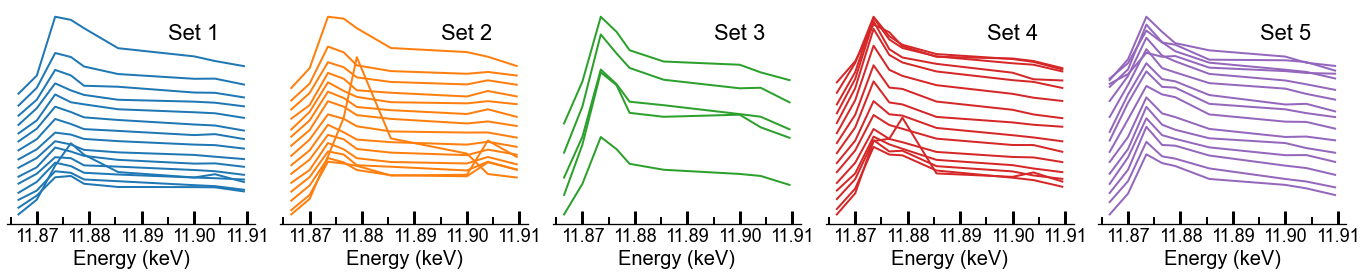

In [16]:
ncols = 5
fig, axes = plt.subplots(figsize=(24, 4), nrows=1, ncols=ncols)
plt.subplots_adjust(wspace=0.1, hspace=0.)

for Set in range(1, 6):
    colm = (Set - 1) % ncols
    ax = axes[colm]
    
    setdata = DATA[Set] 
    for i, pt in enumerate(setdata):
        intensity = np.array(pt['I'], dtype=float)
        ax.plot(np.array(pt['E']) / 1000, intensity / 1000 + i*0.2, '-', linewidth=2, c=plt.cm.tab10(Set - 1))
    
    ax.annotate(f'Set {Set}', (0.65, 0.85), xycoords='axes fraction', fontsize=22)
    
    ax.set_yticks([])
    ax.set_xlabel('Energy (keV)', fontsize=20)
    ax.xaxis.set_minor_locator(MultipleLocator(0.005))
    ax.xaxis.set_major_locator(MultipleLocator(0.010))
    ax.set_xticklabels(np.array(ax.get_xticks(), dtype=float), fontsize=18)
    ax.tick_params(direction='in', width=3, length=13, which='major')
    ax.tick_params(direction='in', width=2, length=7, which='minor')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    set_spine_width(ax, width=1.3)
    turn_off_spines(ax, spines=['top', 'left', 'right'])

plt.savefig('Figures/linescans_smushed.png', dpi=800, transparent=True, bbox_inches='tight')

# Minimization of a reconstruction loss

In [276]:
X_energies = Energies * 1000
interperlator = interp1d(energy, refs)
Y_Refs = interperlator(X_energies)

In [277]:
Y_Refs_filtered = np.array([Y_Refs[i] for i in choice_indices])
#Y_Refs = Y_Refs_filtered

In [278]:
kwargs = {'N': 30, 'scale': 0.0, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Y_Refs, **kwargs)

## Determining the best $\lambda_1$

In [116]:
def get_spectral_loss(data, coeffs, Refs, metric, scale=None):
    preds, truths = [], []
    for i in range(data.shape[0]):
        pred = Refs.T @ coeffs[i]
        if scale is not None:
            pred = pred * scale[i]
        pred = pred - np.min(pred)
        preds.append(pred)
        true = data[i]
        true = true - np.min(true)
        truths.append(truths)
    return eval(metric)(pred, true)

In [120]:
lambdas = np.linspace(0.0, 0.4, 11)
print(lambdas)
Unscaled_errors = {}
Scaled_errors = {}
num_contribs_unscale = {}
num_contribs_scale = {}

for lambda1 in lambdas:
    tol = None
    metric = 'mean_squared_error'
    print(f'{lambda1}  ', end='\r')
    
    unscaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs_filtered, scaling=False, tol=tol, metric=metric,
                                              lambda1=lambda1)
    unscale_err = get_spectral_loss(test_data, unscaled_coeffs, Y_Refs_filtered, metric, scale=None)
    Unscaled_errors[lambda1] = unscale_err
    num_contribs_unscale[lambda1] = np.average(np.sum(unscaled_coeffs != 0, axis=1), axis=0)

    scale, scaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs_filtered, scaling=True, tol=tol, metric=metric,
                                                   lambda1=lambda1)
    scale_err = get_spectral_loss(test_data, scaled_coeffs, Y_Refs_filtered, metric, scale=scale)
    Scaled_errors[lambda1] = scale_err
    num_contribs_scale[lambda1] = np.average(np.sum(scaled_coeffs != 0, axis=1), axis=0)

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4 ]


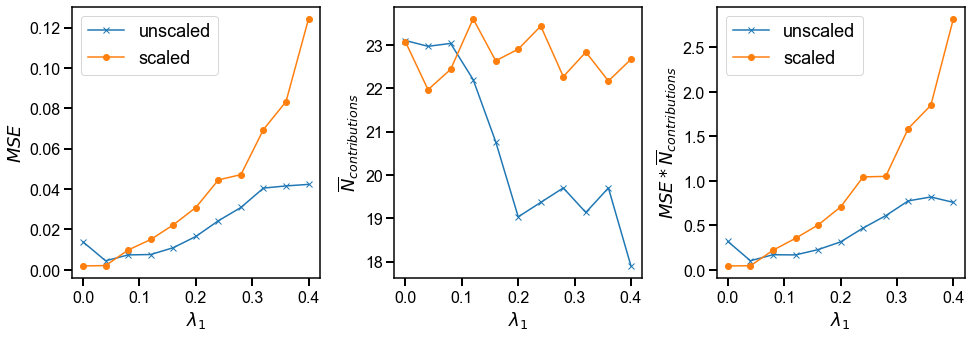

In [130]:
def plot_error_vs_lambda(Unscaled_errors, Scaled_errors,
                         num_contribs_unscale, num_contribs_scale):
    lambdas = np.array(list(Unscaled_errors.keys()))
    
    unscal = np.array(list(Unscaled_errors.values())) * 10
    unscal_contribs = np.array(list(num_contribs_unscale.values()))

    scal = np.array(list(Scaled_errors.values())) * 10
    scal_contribs = np.array(list(num_contribs_scale.values()))
    
    fig, axes = plt.subplots(figsize=(5*3 + 1, 5), ncols=3)
    plt.subplots_adjust(wspace=0.3)
    
    y1 = [unscal, unscal_contribs, unscal * unscal_contribs]
    y2 = [scal, scal_contribs, scal * scal_contribs]
    ylabels = ['$MSE$', '$\overline{N}_{contributions}$', '$MSE * \overline{N}_{contributions}$']

    for i, ax in enumerate(axes):
        ax.plot(lambdas, y1[i], 'x-', c=plt.cm.tab20(0), label='unscaled')
        ax.plot(lambdas, y2[i], 'o-', c=plt.cm.tab20(2), label='scaled')

        if i != 1:
            ax.legend(fontsize=18)
        ax.tick_params(direction='out', width=2, length=8, which='major', axis='both')
        ax.set_ylabel(ylabels[i], fontsize=18)
        ax.set_xlabel('$\lambda_1$', fontsize=18)
        plt.setp(ax.get_xticklabels(), fontsize=16)
        plt.setp(ax.get_yticklabels(), fontsize=16)
        set_spine_width(ax, width=1.5)

plot_error_vs_lambda(Unscaled_errors, Scaled_errors, num_contribs_unscale, num_contribs_scale)
plt.savefig(f'Figures/determining_lambda1.png', dpi=800, bbox_inches='tight', transparent=True)

# Examining tolerance

In [279]:
kwargs = {'N': 5, 'scale': 0.0, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Y_Refs, **kwargs)

In [280]:
tol = 0.05
metric = 'mean_squared_error'
lambda1 = 0.3
unscaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs_filtered, scaling=False, tol=tol, metric=metric,
                                          lambda1=lambda1)
scale, scaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs_filtered, scaling=True, tol=tol, metric=metric,
                                               lambda1=lambda1)

mean squared error: 0.00527400737210151
mean squared error: 0.022741868895892376


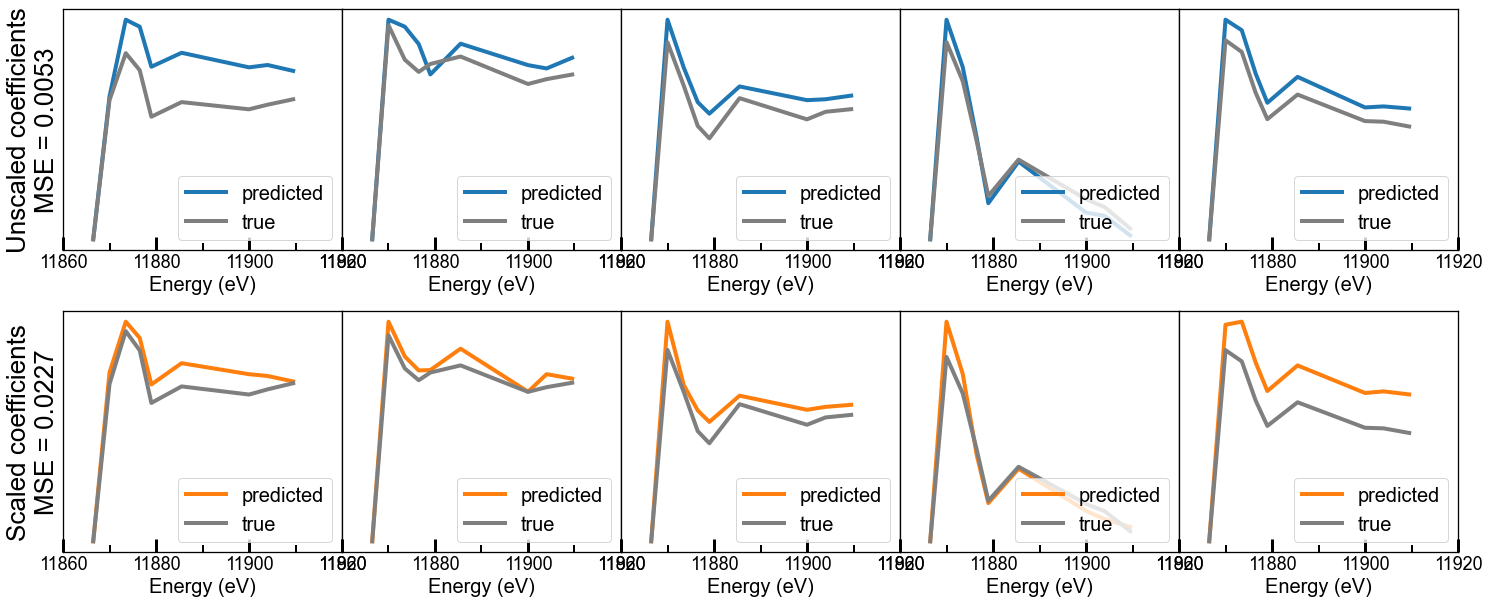

In [281]:
m = 5
fig, axes = plt.subplots(figsize=(5*m, 5*2), ncols=m, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0.25)

unscaled_error = plot_reconstructions((fig, axes[0, :]), test_data, unscaled_coeffs, m, X_energies,
                                       Y_Refs_filtered, metric=metric, color=0)
scaled_error = plot_reconstructions((fig, axes[1, :]), test_data, scaled_coeffs, m, X_energies,
                                     Y_Refs_filtered, scale=scale, metric=metric, color=2)

axes[0, 0].set_ylabel(f'Unscaled coefficients\nMSE = {unscaled_error:.4f}', fontsize=26)
axes[1, 0].set_ylabel(f'Scaled coefficients\nMSE = {scaled_error:.4f}', fontsize=26)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        set_spine_width(axes[i, j], width=1.3) 

plt.savefig(f'Figures/unscaled_vs_scaled_recon_spectra_tol_{tol}_lambda1_{lambda1}.png',
            dpi=800, bbox_inches='tight', transparent=True)

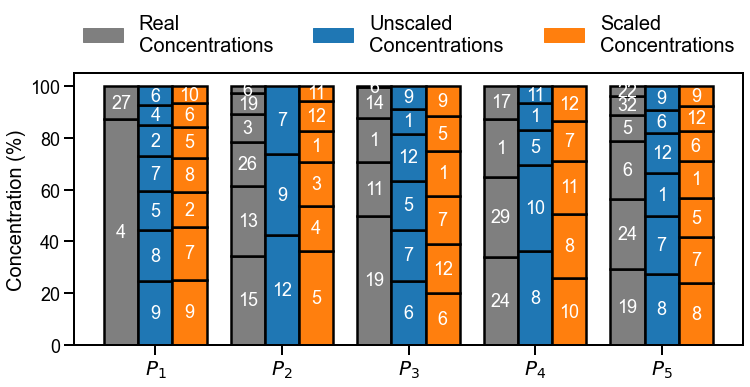

In [282]:
fig, ax = plt.subplots(figsize=(4*3, 5))
titles = ['Real\nConcentrations', 'Unscaled\nConcentrations', 'Scaled\nConcentrations']
coeffs = [test_coeffs, unscaled_coeffs, scaled_coeffs]
width = 0.27
offsets = [-width, 0, width]
colors = [14, 0, 2]

for i in range(3):
    if i == 2:
        ft = True
    else:
        ft = False
    make_conc_bar_chart((fig, ax), coeffs[i], data_columns, width=width,
                         offset=offsets[i], varcolor=colors[i], format_ticks=ft)
patches = [mpatches.Patch(color=plt.cm.tab20(colors[i]), label=titles[i]) for i in range(3)]
legend = ax.legend(handles=patches, frameon=False, fontsize=20, ncol=3,
                   loc='lower center', bbox_to_anchor=(0.5, 1.))
    
plt.savefig(f'Figures/coeff_bar_chart_tol_{tol}.png', dpi=800, bbox_inches='tight', transparent=True)

## Analyze affect of noise on error

In [137]:
metric = 'mean_squared_error'
lambda1 = 0.
noises = np.arange(0, 0.06, 0.01)
Errors = get_errors_with_different_noises(Y_Refs , noises=noises, metric=metric, lambda1=lambda1)

Noise: 0.0%
Noise: 1.0%
Noise: 2.0%
Noise: 3.0%
Noise: 4.0%
Noise: 5.0%


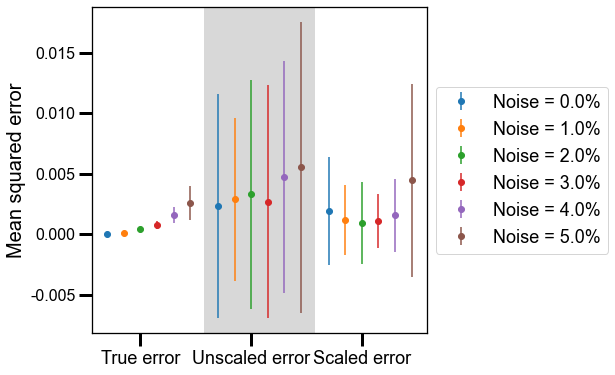

In [138]:
fig, ax = plt.subplots(figsize=(6, 6))

labels = ['True error', 'Unscaled error', 'Scaled error']
ax.axvspan(0.875, 1.875, fc=plt.cm.tab10(7), alpha=0.3)

for i, noise in enumerate(noises):
    errors = Errors[i]
    for j in range(errors.shape[0]):
        err = errors[j, :]
        if j == 0:
            label = f"Noise = {noise * 100}%"
        else:
            label = None
        plt.errorbar(np.array([j]) + i*0.15, np.average(err), yerr=np.std(err), fmt='o',
                     color=plt.cm.tab10(i), label=label)
        
plt.legend(fontsize=18, bbox_to_anchor=(1., 0.5), loc='center left')

ax.tick_params(direction='out', width=3, length=13, which='major', axis='both')

ax.set_ylabel('Mean squared error', fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=16)

x_pos = np.array([i + 0.3 for i, _ in enumerate(labels)])
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.xticks(x_pos, labels, fontsize=18)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
set_spine_width(ax, width=1.3)

plt.savefig('Figures/minimization_optimization_noise_error.png', dpi=800,
            bbox_inches='tight', transparent=True)

# Find coeffs of experimental data using minimimzation with scaling

In [172]:
utils = reload(utils)
from utils import *

Set 3
Getting coeffs...
Setting up bar chart...
Setting up reconstruction plot...
mean absolute error: 0.4686929000712131
mean absolute error: 0.4686929000712131
mean absolute error: 0.4686929000712131
mean absolute error: 0.4686929000712131
mean absolute error: 0.4686929000712131


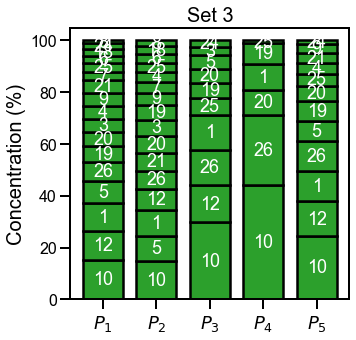

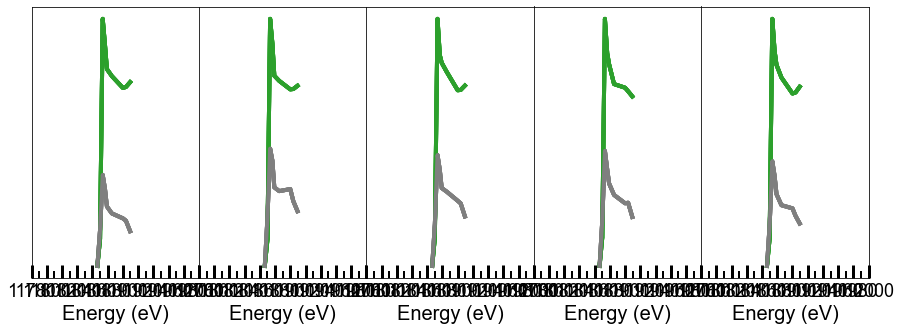

In [188]:
#for Set in range(1, 6):
for Set in [3]:
    print(f'Set {Set}')
    setdata = DATA[Set]
    Spectra = []
    for i, pt in enumerate(setdata):
        spectrum = np.array(pt['I'], dtype=float)
        spectrum = spectrum / np.max(spectrum)
        Spectra.append(spectrum)
    Spectra = np.array(Spectra)
    print('Getting coeffs...')
    
    Scales, Coeffs = get_coeffs_from_spectra(Spectra, Y_Refs, scaling=True,
                                             lambda1=0.3, tol=0.01)
    print('Setting up bar chart...')
    
    fig, ax = plt.subplots(figsize=(len(setdata), 5))
    plt.subplots_adjust(wspace=0, hspace=0.25)
    
    make_conc_bar_chart((fig, ax), Coeffs, data_columns, width=0.75,
                        varcolor=(Set - 1)*2, format_ticks=False)
       
    m = Coeffs.shape[0]
    labels = ["$" + "P_{" + f"{i}" + "}$" for i in range(1, m + 1)]
    ax.set_xticks(np.arange(0, m))
    ax.set_xticklabels(labels, fontsize=18)
    
    plt.setp(ax.get_yticklabels(), fontsize=16)
    
    plt.title(f'Set {Set}', fontsize=20)
    plt.savefig(f'Figures/Set_{Set}_coeff_bar_chart.png', dpi=800, transparent=True)
    
    print('Setting up reconstruction plot...')
    
    m = 5
    N = len(Spectra)
    nrows = N//m
    fig, axes = plt.subplots(figsize=(5*ncols, 5*nrows), ncols=m, nrows=nrows)
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(axes.shape[0]):
        if len(axes.shape) == 2:
            err = plot_reconstructions((fig, axes[i, :]), Spectra, Coeffs, m, X_energies,
                                    Y_Refs, scale=Scales, color=(Set - 1)*2, leg=False)
            for j in range(axes.shape[1]):
                axes[i, j].set_ylabel(None)
                axes[i, j].set_xticks([])
                axes[i, j].set_xticklabels([])
                axes[i, j].tick_params(direction='out', which='major', axis='x')
                set_spine_width(axes[i, j], width=1.3)
        else:
            err = plot_reconstructions((fig, axes), Spectra, Coeffs, m, X_energies,
                                    Y_Refs, scale=Scales, color=(Set - 1)*2, leg=False)

    plt.savefig(f'Figures/Set_{Set}_recon_plot.png',
                dpi=800, bbox_inches='tight', transparent=True)
